# Assignment 4

In [12]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import math

In [2]:
ssu = xr.open_dataset("ssu.nc")
ssv = xr.open_dataset("ssv.nc")

In [3]:
ssu = ssu.rename({"LON881_1120" : "lon", "LAT321_420": "lat", "TIME":"time"})
ssv = ssv.rename({"LON881_1120" : "lon", "LAT321_420": "lat", "TIME":"time"})

In [4]:
ssu

<xarray.Dataset>
Dimensions:  (lon: 240, lat: 100, time: 365)
Coordinates:
  * lon      (lon) float64 40.12 40.38 40.62 40.88 ... 99.12 99.38 99.62 99.88
  * lat      (lat) float64 0.125 0.375 0.625 0.875 ... 24.12 24.38 24.62 24.88
  * time     (time) datetime64[ns] 2022-01-01 2022-01-02 ... 2022-12-31
Data variables:
    UWND     (time, lat, lon) float32 ...
Attributes:
    history:      FERRET V6.5  25-Mar-24
    Conventions:  CF-1.0

In [5]:
ssv

<xarray.Dataset>
Dimensions:  (lon: 240, lat: 100, time: 345)
Coordinates:
  * lon      (lon) float64 40.12 40.38 40.62 40.88 ... 99.12 99.38 99.62 99.88
  * lat      (lat) float64 0.125 0.375 0.625 0.875 ... 24.12 24.38 24.62 24.88
  * time     (time) datetime64[ns] 2022-01-21 2022-01-22 ... 2022-12-31
Data variables:
    VWND     (time, lat, lon) float32 ...
Attributes:
    history:      FERRET V6.5  25-Mar-24
    Conventions:  CF-1.0

## Seasonal means

In [6]:
ssu_summer = ssu.sel(time=slice('2022-06-01', '2022-09-30')).mean('time')
ssu_winter = 0.5*(ssu.sel(time=slice('2022-11-01', '2022-12-31')).mean('time')+ssu.sel(time=slice('2022-01-01', '2022-02-28')).mean('time'))

ssv_summer = ssv.sel(time=slice('2022-06-01', '2022-09-30')).mean('time')
ssv_winter = 0.5*(ssv.sel(time=slice('2022-11-01', '2022-12-31')).mean('time')+ssv.sel(time=slice('2022-01-01', '2022-02-28')).mean('time'))

In [7]:
ssu_summer = ssu_summer["UWND"]
ssu_winter = ssu_winter["UWND"]

ssv_summer = ssv_summer["VWND"]
ssv_winter = ssv_winter["VWND"]

In [8]:
tau_summer = ssu_summer*0.0
tau_summer_x = ssu_summer*0.0
tau_summer_y = ssu_summer*0.0

tau_winter = ssu_summer*0.0
tau_winter_x = ssu_summer*0.0
tau_winter_y = ssu_summer*0.0

## Wind stress calculations

### Summer(JJAS)

In [9]:
rho_a = 1.175

In [14]:
for lat in range(len(ssu_summer.lat)):
    for lon in range(len(ssu_summer.lon)):
        vel = np.sqrt(ssu_summer[lat,lon]*ssu_summer[lat,lon] + ssv_summer[lat,lon]*ssv_summer[lat,lon])
        theta = math.atan(ssu_summer[lat,lon]/ssv_summer[lat,lon])
        if (vel  < 15.):
            cd = 0.001*(0.46 + 0.14*vel)
        else:
            cd = 2.63e-3
        tau_summer[lat,lon] = rho_a * cd * vel * vel
        tau_summer_x[lat,lon] = tau_summer[lat,lon]*np.sin(theta)
        tau_summer_y[lat,lon] = tau_summer[lat,lon]*np.cos(theta)

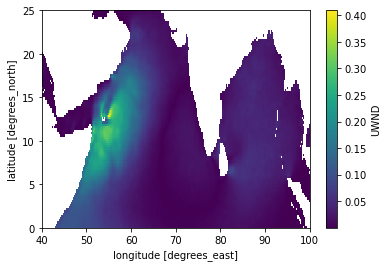

In [34]:
tau_summer_y.plot()

In [39]:
curl_summer = ssu_summer*0.0

for lat in range(len(ssu_summer.lat)-1):
    for lon in range(len(ssu_summer.lon)-1):
        dtauy_dx = (tau_summer_y[lat,lon+1]-tau_summer_y[lat,lon])/(110.*1000.*0.25)
        dtaux_dy = (tau_summer_x[lat+1,lon]-tau_summer_x[lat,lon])/(110.*1000.*0.25)

        curl_summer[lat,lon] = dtauy_dx - dtaux_dy

Text(0, 0.5, 'Latitude')

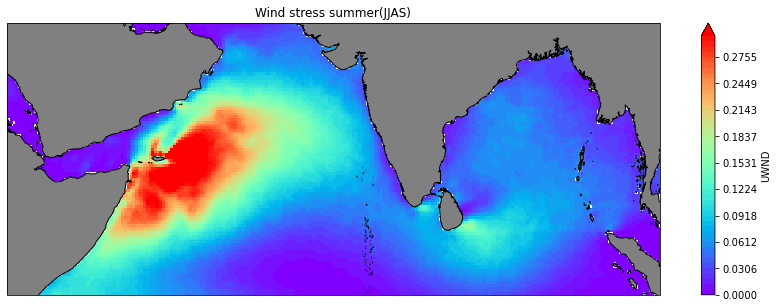

In [23]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(15,5))
ax = plt.axes(projection=proj)
tau_summer.plot(
    x="lon", y="lat", transform=ccrs.PlateCarree(), levels=np.linspace(0.0,0.3,50), cmap="rainbow"
)

coast_10m = cfeature.NaturalEarthFeature(
    "physical", "land", "10m", edgecolor="k", facecolor="0.5"
)
ax.add_feature(coast_10m)
plt.title("Wind stress summer(JJAS)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

Text(0, 0.5, 'Latitude')

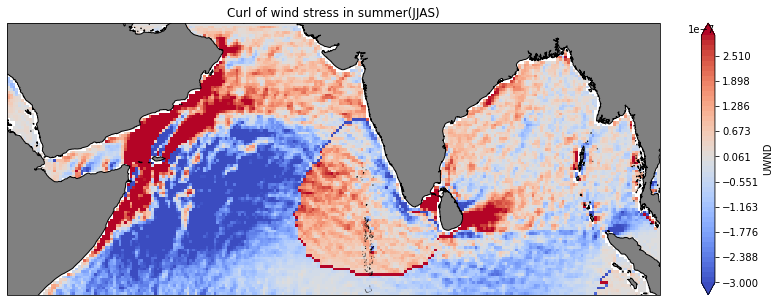

In [60]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(15,5))
ax = plt.axes(projection=proj)
curl_summer.plot(
    x="lon", y="lat", transform=ccrs.PlateCarree(), levels=np.linspace(-.3e-6,.3e-6,50), cmap="coolwarm"
)

coast_10m = cfeature.NaturalEarthFeature(
    "physical", "land", "10m", edgecolor="k", facecolor="0.5"
)
ax.add_feature(coast_10m)
plt.title("Curl of wind stress in summer(JJAS)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

### Winter (NDJF)

In [52]:
for lat in range(len(ssu_winter.lat)):
    for lon in range(len(ssu_winter.lon)):
        vel = np.sqrt(ssu_winter[lat,lon]*ssu_winter[lat,lon] + ssv_winter[lat,lon]*ssv_winter[lat,lon])
        theta = math.atan(ssu_winter[lat,lon]/ssv_winter[lat,lon])
        if (vel  < 15.):
            cd = 0.001*(0.46 + 0.14*vel)
        else:
            cd = 2.63e-3
        tau_winter[lat,lon] = rho_a * cd * vel * vel
        tau_winter_x[lat,lon] = tau_winter[lat,lon]*np.sin(theta)
        tau_winter_y[lat,lon] = tau_winter[lat,lon]*np.cos(theta)

Text(0, 0.5, 'Latitude')

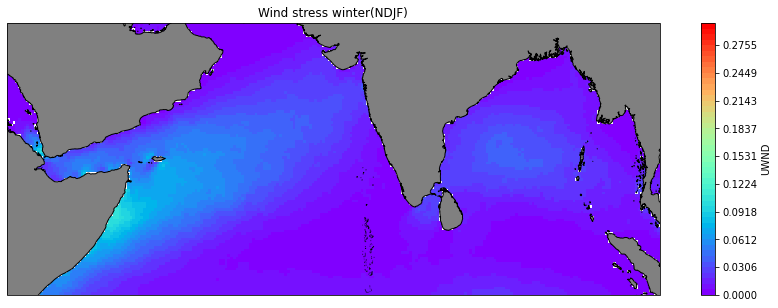

In [53]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(15,5))
ax = plt.axes(projection=proj)
tau_winter.plot(
    x="lon", y="lat", transform=ccrs.PlateCarree(), levels=np.linspace(0.0,0.3,50), cmap="rainbow"
)

coast_10m = cfeature.NaturalEarthFeature(
    "physical", "land", "10m", edgecolor="k", facecolor="0.5"
)
ax.add_feature(coast_10m)
plt.title("Wind stress winter(NDJF)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

In [54]:
curl_winter = ssu_winter*0.0

for lat in range(len(ssu_winter.lat)-1):
    for lon in range(len(ssu_winter.lon)-1):
        dtauy_dx = (tau_winter_y[lat,lon+1]-tau_winter_y[lat,lon])/(110.*1000.*0.25)
        dtaux_dy = (tau_winter_x[lat+1,lon]-tau_winter_x[lat,lon])/(110.*1000.*0.25)

        curl_winter[lat,lon] = dtauy_dx - dtaux_dy

Text(0, 0.5, 'Latitude')

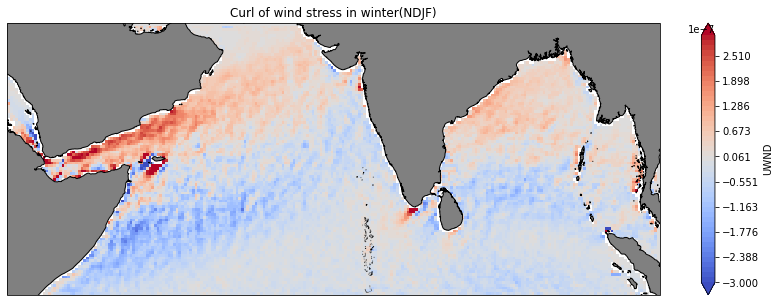

In [59]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(15,5))
ax = plt.axes(projection=proj)
curl_winter.plot(
    x="lon", y="lat", transform=ccrs.PlateCarree(), levels=np.linspace(-0.3e-6, 0.3e-6, 50), cmap="coolwarm"
)

coast_10m = cfeature.NaturalEarthFeature(
    "physical", "land", "10m", edgecolor="k", facecolor="0.5"
)
ax.add_feature(coast_10m)
plt.title("Curl of wind stress in winter(NDJF)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")